# Introduction

## Short description of the problem

We consider a vacuum vessel embodied as a toroidal volume defined by a 2D arbitrary polygon representing in cross-section in (R,Z) coordinates.
We want to efficiently mesh both the volume and the 3D surface of the vessel.

As input, we provide the cross-section polygon and a list dV defining the three resolutions dV = [dR,dZ,dRphi], where each resolution is a distance in meters in the corresponding direction (note the use of dRphi instead of dphi for that purpose).
Indeed, we do not want a simple cylindrical mesh, as we want to capture details in the toroidal (Rphi) direction with a similar accuracy for every value of R.

In most uses, we will only need a fraction of the total mesh. Hence, the routine should not compute the total mesh but only the fraction we need.
For a given resolution dV (i.e. a given tuple of dR,dZ,dRphi), there should be only one possible mesh.
This way, the fraction of interest can be defined either by its physical limits (DR,DZ,DPhi) or by the indices of the mesh elements which are required. 

Hence, we need a methods to 
* Compute the mesh fraction from its limits and return it with its indices
* Compute the mesh fraction from its indices and return it with its limits

Not returning the whole mesh makes sense since it may well be a huge array (memory-expensive). The computation should be as fast as possible.


## Numerical strategy

### Volume

For a given input cross-section polygon VPoly, provided with the required resolutions dR, dZ and dRphi, the total mesh is a torus of rectangular cross-section (R goes from a minimum to a maximum, as Z, and phi goes from -pi to pi). This simplifies the computation of the indices without making the result heavier since only the relevant mesh elements are returned.
The limits of the desired submesh can be provided as DR, DZ and DPhi (note that the toroidal limit is angular as opposed to the toroidal resolution).

The minimum and maximim boundaries of R and Z are also provided. They could be deduced from VPOly but they are explicitly provided for two reasons:
* In ToFu these limits are stored in the Ves object, so it is already available and there is no need to compute it again
* It may happen that a VPoly is slightly modified with no desire to modify the mesh, so it should remain possible to force the boundaries.

The indices are return in numeric form (not boolean), and computed as follows:
* The numbering occurs anti-clockwise from -pi to pi for phi
* Then, it occurs along Z, from its minimum to its maximum value
* Finally it is incremented along R, from its minimum to its maximum value

Hence, we first describe the innermost column (starting from the lowest horizontal ring), and we gradually moved towards the outermost column.

This is necessary since due the desired quasi-constant toroidal accuracy, the number of mesh elements in the toroidal direction is a function of R. 


### Surface

The strategy for meshing the surface is similar, expect that here there are only two resolutions, dL and dRPhi, where dL is the resolution in the poloidal direction along the segments of VPoly.

## Volume meshing 

### Naive python

In [4]:
A = np.random.random((100,))
%timeit len(A)
%timeit A.size

The slowest run took 44.64 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 90.8 ns per loop
The slowest run took 36.53 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 111 ns per loop


### Numpy

In [55]:
10%2

0

In [14]:
import numpy as np

# Preliminary function to get optimal resolution from input resolution
def _Ves_mesh_dlfromL_numpy(LMinMax, dL, DL=None, margin=1.e-9):
    """ Get the actual reolution from the desired resolution and MinMax and limits """
    # Get the number of mesh elements in LMinMax
    N = np.ceil(np.diff(LMinMax)/dL)[0]
    # Derive the real (effective) resolution
    dLr = (np.diff(LMinMax)/N)[0]
    # Get desired limits if any
    DL = LMinMax if DL is None else DL
    # Get the extreme indices of the mesh elements that really need to be created within those limits
    abs0 = np.abs(DL[0]-LMinMax[0])
    if abs0-dLr*np.floor(abs0/dLr)<margin*dLr:
        nL0 = np.round((DL[0]-LMinMax[0])/dLr)
    else:
        nL0 = np.floor((DL[0]-LMinMax[0])/dLr)
    abs1 = np.abs(DL[1]-LMinMax[0])
    if abs1-dLr*np.floor(abs1/dLr)<margin*dLr:
        nL1 = np.round((DL[1]-LMinMax[0])/dLr)-1
    else:
        nL1 = np.floor((DL[1]-LMinMax[0])/dLr)
    # Get the corresponding indices
    indL = np.arange(nL0,nL1+1,1).astype(int)
    # Get the centers of the mesh elements
    L = LMinMax[0] + (0.5 + indL)*dLr
    return L, dLr, indL, N


def _Ves_Vmesh_Phi_numpy(DPhi, dPhir, NRPhi, margin=1.e-9):
    """ Get the min and max indices of the relevant Phi for each R (to be finished) """
    nPhi0 = np.nan*np.ones((dPhir.size,))
    nPhi1 = np.nan*np.ones((dPhir.size,))
    abs0 = np.abs(DPhi[0]+np.pi)
    ind0 = abs0-dPhir*np.floor(abs0/dPhir)<margin*dPhir
    nPhi0[ind0] = np.round((DPhi[0]+np.pi)/dPhir[ind0])
    nPhi0[~ind0] = np.floor((DPhi[0]+np.pi)/dPhir[~ind0])
    abs1 = np.abs(DPhi[1]+np.pi)
    ind1 = abs1-dPhir*np.floor(abs1/dPhir)<margin*dPhir
    nPhi1[ind1] = np.round((DPhi[1]+np.pi)/dPhir[ind1])-1
    nPhi1[~ind1] = np.floor((DPhi[1]+np.pi)/dPhir[~ind1])
    assert np.all(nPhi0>=0) and np.all(nPhi0<=NRPhi)
    assert np.all(nPhi1>=0) and np.all(nPhi1<=NRPhi)
    return nPhi0, nPhi1


def _Ves_Vmesh_Tor_SubFromD_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, DR=None, DZ=None, DPhi=None, VPoly=None, Out='(X,Y,Z)', margin=1.e-9):
    """ Return the desired submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) """
    # Get the actual R and Z resolutions and mesh elements
    R0, dRr0, indR0, NR0 = _Ves_mesh_dlfromL_numpy(RMinMax, dR, None, margin=margin)
    R, dRr, indR, NR = _Ves_mesh_dlfromL_numpy(RMinMax, dR, DR, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_numpy(ZMinMax, dZ, DZ, margin=margin)
    Rn, Zn = len(R), len(Z)

    # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
    NRPhi0 = np.ceil(2.*np.pi*R0/dRPhi)
    NRPhi = np.ceil(2.*np.pi*R/dRPhi)
    dPhir = 2.*np.pi/NRPhi
    # Get the limits if any (and make sure to replace them in the proper quadrants)
    DPhi = [-np.pi,np.pi] if DPhi is None else np.arctan2(np.sin(DPhi),np.cos(DPhi))
    # Later we'll have to remember that the lower limit may be greater than the upper limit due to 2pi modulo
    # Get the two extreme indices of the Phi elements inside the limits for each R
    nPhi0, nPhi1 = _Ves_Vmesh_Phi_numpy(DPhi, dPhir, NRPhi, margin=margin)

    # Compute the centers and indices, using a for loop (no choice) on R
    NRZPhi_cum0 = np.concatenate(([0],NZ*np.cumsum(NRPhi0[:-1])))
    PtsRZP, dV, ind = [], [], []
    for ii in range(0,Rn):
        # Get the phi values
        if DPhi[0]<DPhi[1]:
            indPhi = np.arange(nPhi0[ii],nPhi1[ii]+1)
        else:
            indPhi = np.concatenate((np.arange(nPhi0[ii],NRPhi[ii]),np.arange(0,nPhi1[ii]+1)))
        Phin = len(indPhi)
        phi = -np.pi + (0.5 + indPhi)*dPhir[ii]
        # Get the (R,Z,phi) points
        PtsRZP.append( np.array([R[ii]*np.ones((Phin*Zn,)), np.repeat(Z,Phin), np.tile(phi,Zn)]) )
        # Get the volume
        dV.append( dRr*dZr*dPhir[ii]*R[ii]*np.ones((Phin*Zn,))  )
        # Get the indices
        indii = R0==R[ii]
        ind.append( NRZPhi_cum0[indii] + (indZ[:,np.newaxis]*NRPhi[ii] + indPhi[np.newaxis,:]).flatten() )
        
    PtsRZP = np.concatenate(tuple(PtsRZP),axis=1)
    dV = np.concatenate(tuple(dV))
    ind = np.concatenate(tuple(ind))
    
    # To be commented out once debugged
    assert ind.size==PtsRZP.shape[1]
    assert ind.size==dV.size
    assert np.unique(ind).size==ind.size 

    dRPhir = (dPhir*R)
    """
    if not VPoly is None:
        indin = _Ves_isInside(VPoly, 'Tor', None, PtsRZP[:-1,:], In='(R,Z)')
        PtsRZP, dV, ind = PtsRZP[:,indin], dV[indin], ind[indin]
        Ru = np.unique(PtsRZP[0,:])
        if not Ru==R:
            indii = np.array([R[ii] in Ru for ii in range(0,len(R))], dtype=bool)
            dRPhir = dRPhir[indii]
    """

    if Out.lower()=='(x,y,z)':
        Pts = np.array([PtsRZP[0,:]*np.cos(PtsRZP[2,:]), PtsRZP[0,:]*np.sin(PtsRZP[2,:]), PtsRZP[1,:]])
    else:
        Pts = PtsRZP
        
    return Pts, dV, ind, dRr, dZr, dRPhir

def _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, ind, Out='(X,Y,Z)', margin=1.e-9):
    """ Return the desired submesh indicated by the (numerical) indices, for the desired resolution (dR,dZ,dRphi) """
    # Get the actual R and Z resolutions and mesh elements
    R, dRr, indR, NR = _Ves_mesh_dlfromL_numpy(RMinMax, dR, None, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_numpy(ZMinMax, dZ, None, margin=margin)
    Rn, Zn = len(R), len(Z)

    # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
    NRPhi = np.ceil(2.*np.pi*R/dRPhi)
    dPhir = 2.*np.pi/NRPhi
    NRZPhi_cum = np.concatenate(([0],NZ*np.cumsum(NRPhi[:-1])))
    
    # Get R, Z, and Phi indices
    Nind = ind.size
    indR = ind[:,np.newaxis]-NRZPhi_cum[np.newaxis,:]<0
    indRtemp = np.tile(np.arange(0,NR),(Nind,1))
    indRtemp[indR] = np.nan
    indR = np.nanmax(indRtemp, axis=1).astype(int)
    indZ = ((ind - NRZPhi_cum[indR]) // NRPhi[indR]).astype(int)
    indPhi = ind - NRZPhi_cum[indR] - indZ*NRPhi[indR]
    
    # Derive R, Z and phi values
    PtsRZP = np.array([R[indR], Z[indZ], np.nan*np.ones((Nind,))])
    dV = np.nan*np.ones((Nind,))
    Ru = np.unique(PtsRZP[0,:])
    dRPhir = np.nan*np.ones((len(Ru),))
    for ii in range(0,len(Ru)):
        indRii = (R==Ru[ii]).nonzero()[0]
        indRu = (PtsRZP[0,:]==Ru[ii]).nonzero()[0]
        PtsRZP[2,indRu] = -np.pi + (0.5+indPhi[indRu])*dPhir[indRii]
        dRPhir[ii] = dPhir[indRii]*Ru[ii]
        dV[indRu] = dRr*dZr*dRPhir[ii]
        
    if Out.lower()=='(x,y,z)':
        Pts = np.array([PtsRZP[0,:]*np.cos(PtsRZP[2,:]), PtsRZP[0,:]*np.sin(PtsRZP[2,:]), PtsRZP[1,:]])
    else:
        Pts = PtsRZP

    return Pts, dV, dRr, dZr, dRPhir



### Check and debug

In [2]:
# Check and debug
[dR, dZ, dRPhi], RMinMax, ZMinMax = [0.03]*3, [2.,3.], [-1.,1.]
DR, DZ, DPhi = [2.15,2.6], [-0.21,0.51], [7.*np.pi/4.,5.*np.pi/4.]

Pts0, dV0, ind0, dRr0, dZr0, dRPhir0 = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, Out='(X,Y,Z)')
PtsRZP0 = np.array([np.hypot(Pts0[0,:],Pts0[1,:]), Pts0[2,:],np.arctan2(Pts0[1,:],Pts0[0,:])])
Pts0b, dV0b, dRr0b, dZr0b, dRPhir0b = _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, ind0, Out='(X,Y,Z)')
print "Check 0", [np.allclose(Pts0,Pts0b,atol=1.e-14,rtol=0.,equal_nan=True) for (A,B) in [(Pts0,Pts0b),(dV0,dV0b),(dRr0,dRr0b),(dZr0,dZr0b),(dRPhir0,dRPhir0b)]]

Pts, dV, ind, dRr, dZr, dRPhir = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, DR=DR,DZ=DZ,DPhi=DPhi, Out='(X,Y,Z)')
PtsRZP = np.array([np.hypot(Pts[0,:],Pts[1,:]), Pts[2,:],np.arctan2(Pts[1,:],Pts[0,:])])
Ptsb, dVb, dRrb, dZrb, dRPhirb = _Ves_Vmesh_Tor_SubFromInd_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, ind, Out='(X,Y,Z)')
print "Check 1", [np.allclose(A,B,atol=1.e-14,rtol=0.,equal_nan=True) for (A,B) in [(Pts,Ptsb),(dV,dVb),(dRr,dRrb),(dZr,dZrb),(dRPhir,dRPhirb)]]

Check 0 [True, True, True, True, True]
Check 1 [True, True, True, True, True]


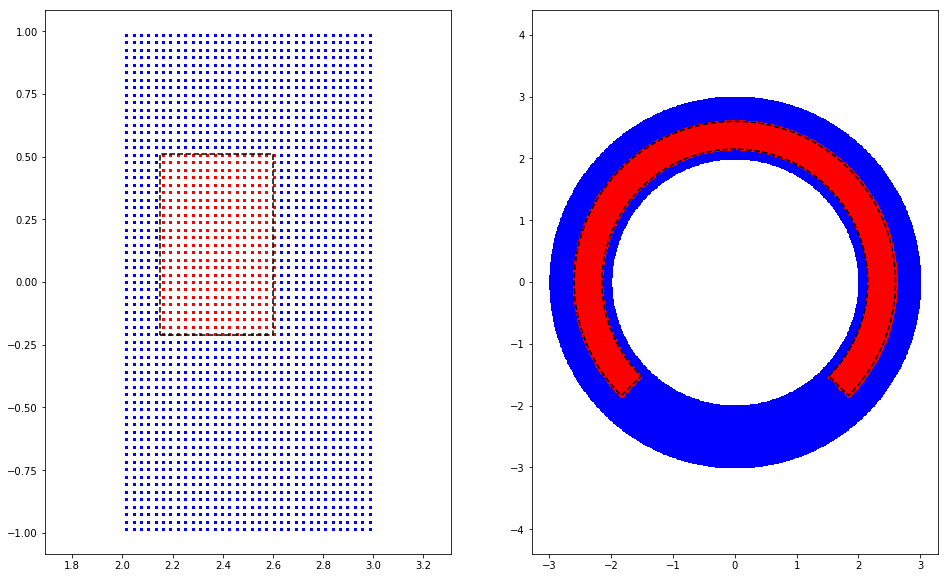

In [3]:
# Plot for check and debug
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(1,2,1, aspect="equal", adjustable="datalim")
plt.plot(PtsRZP0[0,:],PtsRZP0[1,:],'.b', PtsRZP[0,:],PtsRZP[1,:],'.r', markersize=2)
plt.plot([DR[0],DR[1],DR[1],DR[0],DR[0]], [DZ[0],DZ[0],DZ[1],DZ[1],DZ[0]],'--k')

plt.subplot(1,2,2, aspect="equal", adjustable="datalim")
plt.plot(Pts0[0,:],Pts0[1,:],'.b', Pts[0,:],Pts[1,:],'.r', markersize=2)
thet = np.linspace(DPhi[0],DPhi[1],100) if DPhi[0]<DPhi[1] else np.linspace(DPhi[0],DPhi[1]+2.*np.pi,100)
X = np.concatenate((DR[0]*np.cos(thet),DR[1]*np.cos(thet[::-1]),[DR[0]*np.cos(thet[0])]))
Y = np.concatenate((DR[0]*np.sin(thet),DR[1]*np.sin(thet[::-1]),[DR[0]*np.sin(thet[0])]))
plt.plot(X,Y,'--k')

plt.show()

In [6]:
# Check and debug
[dR, dZ, dRPhi], RMinMax, ZMinMax = [0.02]*3, [2.,3.], [-1.,1.]
DR, DZ, DPhi = [2.15,2.6], [-0.21,0.51], [7.*np.pi/4.,5.*np.pi/4.]
Pts0, dV0, ind0, dRr0, dZr0, dRPhir0 = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, Out='(X,Y,Z)')

%timeit out = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, Out='(X,Y,Z)')
%timeit out = _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, ind0, Out='(X,Y,Z)')

1 loop, best of 3: 773 ms per loop
1 loop, best of 3: 6.31 s per loop


### Cython

In [1]:
%load_ext cython

In [52]:
%%cython -a
cimport cython
import numpy as np
cimport numpy as cnp
from cpython cimport bool
from libc.math cimport ceil as Cceil, abs as Cabs, floor as Cfloor, round as Cround
from libc.math cimport cos as Ccos, sin as Csin, atan2 as Catan2, pi as Cpi
from matplotlib.path import Path

import datetime as dtm

# Preliminary function to get optimal resolution from input resolution
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_mesh_dlfromL_cython(double[::1] LMinMax, double dL, DL=None, double margin=1.e-9):
    """ Get the actual reolution from the desired resolution and MinMax and limits """
    # Get the number of mesh elements in LMinMax
    cdef double N = Cceil((LMinMax[1]-LMinMax[0])/dL)
    # Derive the real (effective) resolution
    cdef double dLr = (LMinMax[1]-LMinMax[0])/N
    # Get desired limits if any
    cdef double[::1] DLc, L
    cdef long [::1] indL
    #cdef cnp.ndarray[double,ndim=1] indL, L
    cdef double abs0, abs1, A
    cdef int nL0, nL1, Nind, ii, jj
    if DL is None:
        DLc = LMinMax
    else:
        if DL[0] is None:
            DL[0] = LMinMax[0]
        if DL[1] is None:
            DL[1] = LMinMax[1]
        DLc = np.array(DL)
        
    # Get the extreme indices of the mesh elements that really need to be created within those limits
    abs0 = Cabs(DLc[0]-LMinMax[0])
    if abs0-dLr*Cfloor(abs0/dLr)<margin*dLr:
        nL0 = int(Cround((DLc[0]-LMinMax[0])/dLr))
    else:
        nL0 = int(Cfloor((DLc[0]-LMinMax[0])/dLr))
    abs1 = Cabs(DLc[1]-LMinMax[0])
    if abs1-dLr*Cfloor(abs1/dLr)<margin*dLr:
        nL1 = int(Cround((DLc[1]-LMinMax[0])/dLr)-1)
    else:
        nL1 = int(Cfloor((DLc[1]-LMinMax[0])/dLr))
    # Get the corresponding indices
    Nind = nL1+1-nL0
    indL = np.empty((Nind,),dtype=int)#np.linspace(nL0,nL1,Nind,endpoint=True)
    L = np.empty((Nind,))
    for ii in range(0,Nind):
        jj = nL0+ii
        indL[ii] = jj
        L[ii] = LMinMax[0] + (0.5 + (<double>jj))*dLr
    return np.asarray(L), dLr, np.asarray(indL), N

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Vmesh_Tor_SubFromD_cython(double dR, double dZ, double dRPhi, 
                                   double[::1] RMinMax, double[::1] ZMinMax,
                                   DR=None, DZ=None, DPhi=None, VPoly=None,
                                   str Out='(X,Y,Z)', double margin=1.e-9):
    " Return the desired submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) "
    
    cdef double[::1] R0, R, Z, dRPhir, dPhir, NRPhi#, dPhi, NRZPhi_cum0, indPhi, phi
    cdef double dRr0, dRr, dZr, DPhi0, DPhi1
    cdef double abs0, abs1, phi, indiijj
    cdef long[::1] indR0, indR, indZ, Phin, NRPhi0
    cdef int NR0, NR, NZ, Rn, Zn, nRPhi0, indR0ii, ii, jj, nPhi0, nPhi1, zz, NP, NRPhi_int, Rratio
    cdef cnp.ndarray[double,ndim=2] Pts, indI
    cdef cnp.ndarray[double,ndim=1] dV, ind
    
    # Get the actual R and Z resolutions and mesh elements
    R0, dRr0, indR0, NR0 = _Ves_mesh_dlfromL_cython(RMinMax, dR, None, margin=margin)
    R, dRr, indR, NR = _Ves_mesh_dlfromL_cython(RMinMax, dR, DR, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_cython(ZMinMax, dZ, DZ, margin=margin)
    Rn = len(R)
    Zn = len(Z)
    
    # Get the limits if any (and make sure to replace them in the proper quadrants)
    if DPhi is None:
        DPhi0, DPhi1 = -Cpi, Cpi
    else:
        DPhi0, DPhi1 = Catan2(Csin(DPhi[0]),Ccos(DPhi[0])), Catan2(Csin(DPhi[1]),Ccos(DPhi[1]))
    
    dRPhir, dPhir = np.empty((Rn,)), np.empty((Rn,))
    Phin = np.empty((Rn,),dtype=int)
    NRPhi = np.empty((Rn,))
    NRPhi0 = np.zeros((Rn,),dtype=int)
    nRPhi0, indR0ii = 0, 0
    NP, NPhimax = 0, 0
    Rratio = int(Cceil(R[Rn-1]/R[0]))
    for ii in range(0,Rn):
        # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
        NRPhi[ii] = Cceil(2.*Cpi*R[ii]/dRPhi)
        NRPhi_int = int(NRPhi[ii])
        dPhir[ii] = 2.*Cpi/NRPhi[ii]
        dRPhir[ii] = dPhir[ii]*R[ii]
        # Get index and cumulated indices from background
        for jj in range(indR0ii,NR0):
            if R0[jj]==R[ii]:
                indR0ii = jj
                break
            else:
                nRPhi0 += <long>Cceil(2.*Cpi*R0[jj]/dRPhi)
                NRPhi0[ii] = nRPhi0*NZ
        # Get indices of phi
        # Get the extreme indices of the mesh elements that really need to be created within those limits
        abs0 = Cabs(DPhi0+Cpi)
        if abs0-dPhir[ii]*Cfloor(abs0/dPhir[ii])<margin*dPhir[ii]:
            nPhi0 = int(Cround((DPhi0+Cpi)/dPhir[ii]))
        else:
            nPhi0 = int(Cfloor((DPhi0+Cpi)/dPhir[ii]))
        abs1 = Cabs(DPhi1+Cpi)
        if abs1-dPhir[ii]*Cfloor(abs1/dPhir[ii])<margin*dPhir[ii]:
            nPhi1 = int(Cround((DPhi1+Cpi)/dPhir[ii])-1)
        else:
            nPhi1 = int(Cfloor((DPhi1+Cpi)/dPhir[ii]))
            
        if DPhi0<DPhi1:
            #indI.append(list(range(nPhi0,nPhi1+1)))
            Phin[ii] = nPhi1+1-nPhi0
            if ii==0:
                indI = np.ones((Rn,Phin[ii]*Rratio+1))
            for jj in range(0,Phin[ii]):
                indI[ii,jj] = <double>( nPhi0+jj )
        else:
            #indI.append(list(range(nPhi0,NRPhi_int)+list(range(0,nPhi1+1))))
            Phin[ii] = nPhi1+1+NRPhi_int-nPhi0
            if ii==0:
                indI = np.ones((Rn,Phin[ii]*Rratio+1))
            for jj in range(0,NRPhi_int-nPhi0):
                indI[ii,jj] = <double>( nPhi0+jj )
            for jj in range(NRPhi_int-nPhi0,Phin[ii]):
                indI[ii,jj] = <double>( jj- (NRPhi_int-nPhi0) )
        NP += Zn*Phin[ii]   
    
    Pts = np.empty((3,NP))
    ind = np.empty((NP,))
    dV = np.empty((NP,))
    # Compute Pts, dV and ind
    # This triple loop is the longest part, it takes ~90% of the CPU time
    NP = 0
    if Out.lower()=='(x,y,z)':
        for ii in range(0,Rn):
            for zz in range(0,Zn):
                for jj in range(0,Phin[ii]):
                    indiijj = indI[ii,jj]
                    phi = -Cpi + (0.5+indiijj)*dPhir[ii]
                    Pts[0,NP] = R[ii]*Ccos(phi)
                    Pts[1,NP] = R[ii]*Csin(phi)
                    Pts[2,NP] = Z[zz]
                    ind[NP] = NRPhi0[ii] + indZ[zz]*NRPhi[ii] + indiijj
                    dV[NP] = dRr*dZr*dRPhir[ii]
                    NP += 1
    else:
        for ii in range(0,Rn):
            for zz in range(0,Zn):
                for jj in range(0,Phin[ii]):
                    indiijj = indI[ii,jj]
                    Pts[0,NP] = R[ii]
                    Pts[1,NP] = Z[zz]
                    Pts[2,NP] = -Cpi + (0.5+indiijj)*dPhir[ii]
                    ind[NP] = NRPhi0[ii] + indZ[zz]*NRPhi[ii] + indiijj
                    dV[NP] = dRr*dZr*dRPhir[ii]
                    NP += 1

    if not VPoly is None:
        indin = Path(VPoly.T).contains_points(PtsRZP[:-1,:].T, transform=None, radius=0.0)
        PtsRZP, dV, ind = PtsRZP[:,indin], dV[indin], ind[indin]
        Ru = np.unique(PtsRZP[0,:])
        if not Ru==R:
            indii = np.array([R[ii] in Ru for ii in range(0,len(R))], dtype=bool)
            dRPhir = dRPhir[indii]
    return Pts, dV, ind.astype(int), dRr, dZr, np.asarray(dRPhir)
    
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Vmesh_Tor_SubFromInd_cython(double dR, double dZ, double dRPhi, 
                                     double[::1] RMinMax, double[::1] ZMinMax, long[::1] ind, 
                                     str Out='(X,Y,Z)', double margin=1.e-9):
    """ Return the desired submesh indicated by the (numerical) indices, for the desired resolution (dR,dZ,dRphi) """
    cdef double[::1] R, Z, dRPhirRef, dPhir, Ru, dRPhir
    cdef double dRr, dZr, phi
    cdef long[::1] indR, indZ, NRPhi0, NRPhi
    cdef long NR, NZ, Rn, Zn, NP=len(ind), Rratio
    cdef int ii, jj, iiR, iiZ, iiphi
    cdef double[:,::1] Phi
    cdef cnp.ndarray[double,ndim=2] Pts=np.empty((3,NP))
    cdef cnp.ndarray[double,ndim=1] dV=np.empty((NP,))
    
    # Get the actual R and Z resolutions and mesh elements
    R, dRr, indR, NR = _Ves_mesh_dlfromL_cython(RMinMax, dR, None, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_cython(ZMinMax, dZ, None, margin=margin)
    Rn, Zn = len(R), len(Z)
    
    # Number of Phi per R
    dRPhirRef, dPhir = np.empty((NR,)), np.empty((NR,))
    Ru, dRPhir = np.zeros((NR,)), np.nan*np.ones((NR,))
    NRPhi, NRPhi0 = np.empty((NR,),dtype=int), np.empty((NR+1,),dtype=int)
    Rratio = int(Cceil(R[NR-1]/R[0]))
    for ii in range(0,NR):
        NRPhi[ii] = <long>(Cceil(2.*Cpi*R[ii]/dRPhi))
        dRPhirRef[ii] = 2.*Cpi*R[ii]/<double>(NRPhi[ii])
        dPhir[ii] = 2.*Cpi/<double>(NRPhi[ii])
        if ii==0:
            NRPhi0[ii] = 0
            Phi = np.empty((NR,NRPhi[ii]*Rratio+1))
        else:
            NRPhi0[ii] = NRPhi0[ii-1] + NRPhi[ii-1]*NZ
        for jj in range(0,NRPhi[ii]):
            Phi[ii,jj] = -Cpi + (0.5+<double>jj)*dPhir[ii]
            
    if Out.lower()=='(x,y,z)':
        for ii in range(0,NP):
            for jj in range(0,NR+1):
                if ind[ii]-NRPhi0[jj]<0.:
                    break
            iiR = jj-1
            iiZ = (ind[ii] - NRPhi0[iiR])//NRPhi[iiR]
            iiphi = ind[ii] - NRPhi0[iiR] - iiZ*NRPhi[iiR]
            phi = Phi[iiR,iiphi]
            Pts[0,ii] = R[iiR]*Ccos(phi)
            Pts[1,ii] = R[iiR]*Csin(phi)
            Pts[2,ii] = Z[iiZ]
            dV[ii] = dRr*dZr*dRPhirRef[iiR]
            if Ru[iiR]==0.:
                dRPhir[iiR] = dRPhirRef[iiR]
                Ru[iiR] = 1.
    else: 
        for ii in range(0,NP):
            for jj in range(0,NR+1):
                if ind[ii]-NRPhi0[jj]<0.:
                    break
            iiR = jj-1
            iiZ = (ind[ii] - NRPhi0[iiR])//NRPhi[iiR]
            iiphi = ind[ii] - NRPhi0[iiR] - iiZ*NRPhi[iiR]
            Pts[0,ii] = R[iiR]
            Pts[1,ii] = Z[iiZ]
            Pts[2,ii] = Phi[iiR,iiphi]
            dV[ii] = dRr*dZr*dRPhirRef[iiR]
            if Ru[iiR]==0.:
                dRPhir[iiR] = dRPhirRef[iiR]
                Ru[iiR] = 1.
    
    return Pts, dV, dRr, dZr, np.asarray(dRPhir)[~np.isnan(dRPhir)]
   
    
    
    
def _Ves_Vmesh_Lin_SubFromD_cython(double dX, double dY, double dZ, 
                                   double[::1] XMinMax, double[::1] YMinMax, double[::1] ZMinMax,
                                   DX=None, DY=None, DZ=None, VPoly=None,
                                   double margin=1.e-9):
    " Return the desired submesh indicated by the limits (DX,DY,DZ), for the desired resolution (dX,dY,dZ) "
    
    cdef double[::1] X, Y, Z
    cdef double dXr, dYr, dZr, dV
    cdef cnp.ndarray[long,ndim=1] indX, indY, indZ
    cdef int NX, NY, NZ, Xn, Yn, Zn
    cdef cnp.ndarray[double,ndim=2] Pts
    cdef cnp.ndarray[long,ndim=1] ind
    
    # Get the actual X, Y and Z resolutions and mesh elements
    X, dXr, indX, NX = _Ves_mesh_dlfromL_cython(XMinMax, dX, DX, margin=margin)
    Y, dYr, indY, NY = _Ves_mesh_dlfromL_cython(YMinMax, dY, DY, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_cython(ZMinMax, dZ, DZ, margin=margin)
    Xn, Yn, Zn = len(X), len(Y), len(Z)
        
    Pts = np.array([np.tile(X,(Yn*Zn,1)).flatten(), np.tile(np.repeat(Y,Xn),(Zn,1)).flatten(), np.repeat(Z,Xn*Yn)])
    ind = np.repeat(NX*NY*indZ,Xn*Yn) + np.tile(np.repeat(NX*indY,Xn),(Zn,1)).flatten() + np.tile(indX,(Yn*Zn,1)).flatten()
    dV = dXr*dYr*dZr
    
    #if VPoly is not None:
    #    indin = _Ves_isInside(Pts[:-1,:], VPoly=VPoly, VType='Lin', In='(X,Y)')
    #    Pts, dV, ind = Pts[:,indin], dV[indin], ind[indin]
    
    return Pts, dV, ind.astype(int), dXr, dYr, dZr
    

def _Ves_Vmesh_Lin_SubFromInd_cython(double dX, double dY, double dZ, 
                                     double[::1] XMinMax, double[::1] YMinMax, double[::1] ZMinMax,
                                     cnp.ndarray[long,ndim=1] ind, double margin=1.e-9):
    " Return the desired submesh indicated by the limits (DX,DY,DZ), for the desired resolution (dX,dY,dZ) "
    
    cdef cnp.ndarray[double,ndim=1] X, Y, Z
    cdef double dXr, dYr, dZr, dV
    cdef long[::1] bla
    cdef cnp.ndarray[long,ndim=1] indX, indY, indZ
    cdef int NX, NY, NZ, Xn, Yn, Zn
    cdef cnp.ndarray[double,ndim=2] Pts
    
    # Get the actual X, Y and Z resolutions and mesh elements
    X, dXr, bla, NX = _Ves_mesh_dlfromL_cython(XMinMax, dX, None, margin=margin)
    Y, dYr, bla, NY = _Ves_mesh_dlfromL_cython(YMinMax, dY, None, margin=margin)
    Z, dZr, bla, NZ = _Ves_mesh_dlfromL_cython(ZMinMax, dZ, None, margin=margin)
    
    #print NX, NY, NZ
    indZ = ind // (NX*NY)
    indY = (ind - NX*NY*indZ) // NX
    indX = ind - NX*NY*indZ - NX*indY
    #print ind
    #print indZ
    #print indY
    #print indX
    Pts = np.array([X[indX.astype(int)], Y[indY.astype(int)], Z[indZ.astype(int)]])
    dV = dXr*dYr*dZr
    
    return Pts, dV, dXr, dYr, dZr
    
    
    

In [17]:
[dR, dZ, dRPhi], RMinMax, ZMinMax = np.asarray([0.01]*3), np.array([2.,3.]), np.array([-1.,1.])
DR, DZ, DPhi = [2.15,2.6], [-0.21,0.51], [7.*np.pi/4.,5.*np.pi/4.]

Ptsc, dVc, indc, dRrc, dZrc, dRPhirc = _Ves_Vmesh_Tor_SubFromD_cython(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                      DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None,
                                                                      Out='(R,Z,phi)', margin=1.e-9)
PtsnI, dVnI, dRrnI, dZrnI, dRPhirnI = _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                      ind=indc, Out='(R,Z,Phi)', margin=1.e-9)
PtscI, dVcI, dRrcI, dZrcI, dRPhircI = _Ves_Vmesh_Tor_SubFromInd_cython(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                       ind=indc, Out='(R,Z,phi)', margin=1.e-9)

print dRPhirc.shape, dRPhirnI.shape, dRPhircI.shape
print dRPhirnI
print dRPhircI

(46,) (46,) (46,)
[ 0.0099981   0.00999282  0.00999493  0.00999702  0.0099991   0.00999391
  0.00999598  0.00999803  0.00999291  0.00999496  0.00999699  0.009999
  0.00999397  0.00999598  0.00999797  0.00999994  0.00999499  0.00999696
  0.00999891  0.00999403  0.00999598  0.00999791  0.00999982  0.00999502
  0.00999693  0.00999882  0.00999409  0.00999598  0.00999785  0.00999971
  0.00999505  0.0099969   0.00999874  0.00999414  0.00999598  0.0099978
  0.00999961  0.00999507  0.00999688  0.00999867  0.00999419  0.00999598
  0.00999775  0.00999951  0.0099951   0.00999685]
[ 0.0099981   0.00999282  0.00999493  0.00999702  0.0099991   0.00999391
  0.00999598  0.00999803  0.00999291  0.00999496  0.00999699  0.009999
  0.00999397  0.00999598  0.00999797  0.00999994  0.00999499  0.00999696
  0.00999891  0.00999403  0.00999598  0.00999791  0.00999982  0.00999502
  0.00999693  0.00999882  0.00999409  0.00999598  0.00999785  0.00999971
  0.00999505  0.0099969   0.00999874  0.00999414  0.00999598 

In [34]:
LMinMax, dL, DL, margin = np.array([0.,10.]), 0.0001, [1.,9.], 1.e-9
Ln, dLrn, indLn, NLn = _Ves_mesh_dlfromL_numpy(LMinMax, dL, DL=DL, margin=margin)
Lc, dLrc, indLc, NLc = _Ves_mesh_dlfromL_cython(LMinMax, dL, DL=DL, margin=margin)

# Check and debug Tor
[dR, dZ, dRPhi], RMinMax, ZMinMax = np.asarray([0.02]*3), np.array([4.,8.]), np.array([-4.,4.])
DR, DZ, DPhi = np.array([5.,6.5]), np.array([-1.5,2.]), np.array([-np.pi/4.,np.pi/4.])
Ptsn, dVn, indn, dRrn, dZrn, dRPhirn = _Ves_Vmesh_Tor_SubFromD_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                     DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None,
                                                                     Out='(R,Z,Phi)', margin=1.e-9)
Ptsc, dVc, indc, dRrc, dZrc, dRPhirc = _Ves_Vmesh_Tor_SubFromD_cython(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                      DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None,
                                                                      Out='(R,Z,phi)', margin=1.e-9)

PtsnI, dVnI, dRrnI, dZrnI, dRPhirnI = _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                      ind=indn, Out='(R,Z,Phi)', margin=1.e-9)
PtscI, dVcI, dRrcI, dZrcI, dRPhircI = _Ves_Vmesh_Tor_SubFromInd_cython(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                       ind=indc, Out='(R,Z,Phi)', margin=1.e-9)

print Ptsn.shape[1], 'points'
%timeit Ln, dLrn, indLn, NLn = _Ves_mesh_dlfromL_numpy(LMinMax, dL, DL=DL, margin=margin)
%timeit Lc, dLrc, indLc, NLc = _Ves_mesh_dlfromL_cython(LMinMax, dL, DL=DL, margin=margin)
print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Ln,Lc),(dLrn,dLrc),(indLn,indLc),(NLn,NLc)]]

%timeit out = _Ves_Vmesh_Tor_SubFromD_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None)
%timeit out = _Ves_Vmesh_Tor_SubFromD_cython(dR, dZ, dRPhi, RMinMax, ZMinMax, DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None, Out='(X,Y,Z)')
print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Ptsn,Ptsc),(dVn,dVc),(indn,indc),(dRPhirn,dRPhirc)]]

%timeit out = _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, ind=indn, Out='(R,Z,Phi)', margin=1.e-9)
%timeit out = _Ves_Vmesh_Tor_SubFromInd_cython(dR, dZ, dRPhi, RMinMax, ZMinMax, ind=indc, Out='(R,Z,Phi)', margin=1.e-9)
print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(PtsnI,PtscI),(dVnI,dVcI),(dRPhirnI,dRPhircI)]]
print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Ptsc,PtscI),(dVc,dVcI),(dRPhirc,dRPhircI)]]


5940900 points
1000 loops, best of 3: 909 µs per loop
1000 loops, best of 3: 550 µs per loop
[True, True, True, True]
1 loop, best of 3: 1.01 s per loop
1 loop, best of 3: 541 ms per loop
[True, True, True, True]
1 loop, best of 3: 25.2 s per loop
1 loop, best of 3: 1.31 s per loop
[True, True, True]
[True, True, True]


In [18]:
# Check and debug Lin
[dX, dY, dZ], XMinMax, YMinMax, ZMinMax = np.asarray([0.01]*3), np.array([-1,1.]), np.array([-1.,1]), np.array([0.,4.])
DX, DY, DZ = [-0.5,0.5], [-0.5,0.5], [1.,3.]
Ptsn, dVn, indn, dXrn, dYrn, dZrn = _Ves_Vmesh_Lin_SubFromD_cython(dX, dY, dZ, XMinMax, YMinMax, ZMinMax,
                                                                   DX=DX, DY=DY, DZ=DZ, VPoly=None, margin=1.e-9)
Ptsc, dVc, dXrc, dYrc, dZrc = _Ves_Vmesh_Lin_SubFromInd_cython(dX, dY, dZ, XMinMax, YMinMax, ZMinMax,
                                                                     indn, margin=1.e-9)

print Ptsn.shape[1], 'points'
%timeit out = _Ves_Vmesh_Lin_SubFromD_cython(dX, dY, dZ, XMinMax, YMinMax, ZMinMax, DX=DX, DY=DY, DZ=DZ, VPoly=None, margin=1.e-9)
%timeit out = _Ves_Vmesh_Lin_SubFromInd_cython(dX, dY, dZ, XMinMax, YMinMax, ZMinMax, indn, margin=1.e-9)
print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Ptsn,Ptsc),(dVn,dVc)]]


2000000 points
10 loops, best of 3: 86.7 ms per loop
10 loops, best of 3: 235 ms per loop
[True, True]


## Surface meshing

In [1]:
%load_ext cython

In [9]:
%%cython -a

cimport cython
cimport numpy as cnp
from cpython cimport bool
from libc.math cimport sqrt as Csqrt, ceil as Cceil, round as Cround, floor as Cfloor, abs as Cabs
from libc.math cimport cos as Ccos, sin as Csin, atan2 as Catan2, pi as Cpi
from matplotlib.path import Path

import numpy as np

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_mesh_dlfromL_cython(double[::1] LMinMax, double dL, DL=None, double margin=1.e-9):
    """ Get the actual reolution from the desired resolution and MinMax and limits """
    # Get the number of mesh elements in LMinMax
    cdef double N = Cceil((LMinMax[1]-LMinMax[0])/dL)
    # Derive the real (effective) resolution
    cdef double dLr = (LMinMax[1]-LMinMax[0])/N
    # Get desired limits if any
    cdef double[::1] DLc, L
    cdef long [::1] indL
    #cdef cnp.ndarray[double,ndim=1] indL, L
    cdef double abs0, abs1, A
    cdef int nL0, nL1, Nind, ii, jj
    cdef list dl
    if DL is None:
        DLc = LMinMax
    else:
        dl = list(DL)
        if dl[0] is None:
            dl[0] = LMinMax[0]
        if dl[1] is None:
            dl[1] = LMinMax[1]
        DLc = np.array(dl)
    # Get the extreme indices of the mesh elements that really need to be created within those limits
    abs0 = Cabs(DLc[0]-LMinMax[0])
    if abs0-dLr*Cfloor(abs0/dLr)<margin*dLr:
        nL0 = int(Cround((DLc[0]-LMinMax[0])/dLr))
    else:
        nL0 = int(Cfloor((DLc[0]-LMinMax[0])/dLr))
    abs1 = Cabs(DLc[1]-LMinMax[0])
    if abs1-dLr*Cfloor(abs1/dLr)<margin*dLr:
        nL1 = int(Cround((DLc[1]-LMinMax[0])/dLr)-1)
    else:
        nL1 = int(Cfloor((DLc[1]-LMinMax[0])/dLr))
    # Get the corresponding indices
    Nind = nL1+1-nL0
    indL = np.empty((Nind,),dtype=int)#np.linspace(nL0,nL1,Nind,endpoint=True)
    L = np.empty((Nind,))
    for ii in range(0,Nind):
        jj = nL0+ii
        indL[ii] = jj
        L[ii] = LMinMax[0] + (0.5 + (<double>jj))*dLr
    return np.asarray(L), dLr, np.asarray(indL), N


@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_mesh_CrossPoly(double[:,::1] VPoly, double dL, D1=None, D2=None, double margin=1.e-9, double DIn=0., VIn=None):
    cdef int ii, jj, nn=0, NP=VPoly.shape[1]
    cdef double[::1] LMinMax, L
    cdef double v0, v1, dlr
    cdef long[::1] indL
    cdef cnp.ndarray[long,ndim=1] N, ind
    cdef cnp.ndarray[double,ndim=1] dLr, Rref
    cdef cnp.ndarray[double,ndim=2] PtsCross
    cdef list LPtsCross=[], LdLr=[], Lind=[], LRref=[], VPolybis=[]
    
    LMinMax = np.array([0.,1.],dtype=float)
    N = np.empty((NP-1,),dtype=int)
    if DIn==0.:
        for ii in range(0,NP-1):
            v0, v1 = VPoly[0,ii+1]-VPoly[0,ii], VPoly[1,ii+1]-VPoly[1,ii]
            LMinMax[1] = Csqrt(v0**2 + v1**2)
            L, dlr, indL, N[ii] = _Ves_mesh_dlfromL_cython(LMinMax, dL, DL=None, margin=margin)
            VPolybis.append((VPoly[0,ii],VPoly[1,ii]))
            v0, v1 = v0/LMinMax[1], v1/LMinMax[1]
            for jj in range(0,N[ii]):
                LdLr.append(dlr)
                LRref.append(VPoly[0,ii] + L[jj]*v0)
                LPtsCross.append((VPoly[0,ii] + L[jj]*v0, VPoly[1,ii] + L[jj]*v1))
                Lind.append(nn)
                nn += 1
                VPolybis.append((VPoly[0,ii] + jj*dlr*v0, VPoly[1,ii] + jj*dlr*v1))
        VPolybis.append((VPoly[0,0],VPoly[1,0]))
    else:
        for ii in range(0,NP-1):
            v0, v1 = VPoly[0,ii+1]-VPoly[0,ii], VPoly[1,ii+1]-VPoly[1,ii]
            LMinMax[1] = Csqrt(v0**2 + v1**2)
            L, dlr, indL, N[ii] = _Ves_mesh_dlfromL_cython(LMinMax, dL, DL=None, margin=margin)
            VPolybis.append((VPoly[0,ii],VPoly[1,ii]))
            v0, v1 = v0/LMinMax[1], v1/LMinMax[1]
            for jj in range(0,N[ii]):
                LdLr.append(dlr)
                LRref.append(VPoly[0,ii] + L[jj]*v0)
                LPtsCross.append((VPoly[0,ii] + L[jj]*v0 + DIn*VIn[0,ii], VPoly[1,ii] + L[jj]*v1 + DIn*VIn[1,ii]))
                Lind.append(nn)
                nn += 1
                VPolybis.append((VPoly[0,ii] + jj*dlr*v0, VPoly[1,ii] + jj*dlr*v1))
        VPolybis.append((VPoly[0,0],VPoly[1,0]))
    
    PtsCross, dLr, ind, Rref = np.array(LPtsCross).T, np.array(LdLr), np.array(Lind,dtype=int), np.array(LRref)
    if D1 is not None:
        indin = (PtsCross[0,:]>=D1[0]) & (PtsCross[0,:]<=D1[1])
        PtsCross = PtsCross[:,indin]
        dLr, ind = dLr[indin], ind[indin]
    if D2 is not None:
        indin = (PtsCross[1,:]>=D2[0]) & (PtsCross[1,:]<=D2[1])
        PtsCross = PtsCross[:,indin]
        dLr, ind = dLr[indin], ind[indin]   
    
    return PtsCross, dLr, ind, N, Rref, np.array(VPolybis).T
    
    

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Smesh_Tor_SubFromD_cython(double dL, double dRPhi, 
                                   double[:,::1] VPoly,
                                   DR=None, DZ=None, DPhi=None,
                                   double DIn=0., VIn=None, PhiMinMax=None,
                                   str Out='(X,Y,Z)', double margin=1.e-9):
    " Return the desired surfacic submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) "
    cdef double[::1] R, Z, dPhir, NRPhi#, dPhi, NRZPhi_cum0, indPhi, phi
    cdef double dRr0, dRr, dZr, DPhi0, DPhi1, DPhiMinMax
    cdef double abs0, abs1, phi, indiijj
    cdef long[::1] indR0, indR, indZ, Phin, NRPhi0, Indin
    cdef int NR0, NR, NZ, Rn, Zn, nRPhi0, indR0ii, ii, jj0, jj, nPhi0, nPhi1, zz, NP, NRPhi_int, Rratio, Ln
    cdef cnp.ndarray[double,ndim=2] Pts, indI, PtsCross, VPbis
    cdef cnp.ndarray[double,ndim=1] R0, dS, ind, dLr, Rref, dRPhir
    cdef cnp.ndarray[long,ndim=1] indL, NL
    
    # Pre-format input
    if PhiMinMax is None:
        PhiMinMax = [-Cpi,Cpi]
        DPhiMinMax = 2.*Cpi
    else:
        PhiMinMax = [Catan2(Csin(PhiMinMax[0]),Ccos(PhiMinMax[0])), Catan2(Csin(PhiMinMax[1]),Ccos(PhiMinMax[1]))]
        if PhiMinMax[1]>=PhiMinMax[0]:
            DPhiMinMax = PhiMinMax[1]-PhiMinMax[0]
        else:
            DPhiMinMax = 2.*Cpi + PhiMinMax[1] - PhiMinMax[0]
        
    
    # Get the actual R and Z resolutions and mesh elements
    PtsCross, dLr, indL, NL, Rref, VPbis = _Ves_mesh_CrossPoly(VPoly, dL, D1=None, D2=None, margin=margin, DIn=DIn, VIn=VIn)
    R0 = np.copy(Rref)
    NR0 = R0.size
    indin = np.ones((PtsCross.shape[1],),dtype=bool)
    if DR is not None:
        indin = indin & (R0>=DR[0]) & (R0<=DR[1])
    if DZ is not None:
        indin = indin & (PtsCross[1,:]>=DZ[0]) & (PtsCross[1,:]<=DZ[1])
    PtsCross, dLr, indL, Rref = PtsCross[:,indin], dLr[indin], indL[indin], Rref[indin]
    Ln = indin.sum()
    Indin = indin.nonzero()[0]
    
    # Get the limits if any (and make sure to replace them in the proper quadrants)
    if DPhi is None:
        DPhi0, DPhi1 = PhiMinMax[0], PhiMinMax[1]
    else:
        DPhi0 = PhiMinMax[0] if DPhi[0] is None else Catan2(Csin(DPhi[0]),Ccos(DPhi[0]))
        DPhi1 = PhiMinMax[1] if DPhi[1] is None else Catan2(Csin(DPhi[1]),Ccos(DPhi[1]))
    dRPhir, dPhir = np.empty((Ln,)), np.empty((Ln,))
    Phin = np.empty((Ln,),dtype=int)
    NRPhi = np.empty((Ln,))
    NRPhi0 = np.zeros((Ln,),dtype=int)
    nRPhi0, indR0ii = 0, 0
    NP, NPhimax = 0, 0
    Rratio = int(Cceil(np.max(Rref)/np.min(Rref)))
    for ii in range(0,Ln):
        # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
        NRPhi[ii] = Cceil(DPhiMinMax*Rref[ii]/dRPhi)
        NRPhi_int = int(NRPhi[ii])
        dPhir[ii] = DPhiMinMax/NRPhi[ii]
        dRPhir[ii] = dPhir[ii]*Rref[ii]
        # Get index and cumulated indices from background
        for jj0 in range(indR0ii,NR0):
            if jj0==Indin[ii]:
                indR0ii = jj0
                break
            else:
                nRPhi0 += <long>Cceil(DPhiMinMax*R0[jj0]/dRPhi)
                NRPhi0[ii] = nRPhi0
        # Get indices of phi
        # Get the extreme indices of the mesh elements that really need to be created within those limits
        abs0 = Cabs(DPhi0-PhiMinMax[0])
        if abs0-dPhir[ii]*Cfloor(abs0/dPhir[ii])<margin*dPhir[ii]:
            nPhi0 = int(Cround((DPhi0-PhiMinMax[0])/dPhir[ii]))
        else:
            nPhi0 = int(Cfloor((DPhi0-PhiMinMax[0])/dPhir[ii]))
        abs1 = Cabs(DPhi1-PhiMinMax[0])
        if abs1-dPhir[ii]*Cfloor(abs1/dPhir[ii])<margin*dPhir[ii]:
            nPhi1 = int(Cround((DPhi1-PhiMinMax[0])/dPhir[ii])-1)
        else:
            nPhi1 = int(Cfloor((DPhi1-PhiMinMax[0])/dPhir[ii]))
        if DPhi0<DPhi1:
            Phin[ii] = nPhi1+1-nPhi0
            if ii==0:
                indI = np.ones((Ln,Phin[ii]*Rratio+1))
            for jj in range(0,Phin[ii]):
                indI[ii,jj] = <double>( nPhi0+jj )
        else:
            Phin[ii] = nPhi1+1+NRPhi_int-nPhi0
            if ii==0:
                indI = np.ones((Ln,Phin[ii]*Rratio+1))
            for jj in range(0,NRPhi_int-nPhi0):
                indI[ii,jj] = <double>( nPhi0+jj )
            for jj in range(NRPhi_int-nPhi0,Phin[ii]):
                indI[ii,jj] = <double>( jj- (NRPhi_int-nPhi0) )
        NP += Phin[ii]
    
    # Finish counting to get total number of points
    if jj0<=NR0-1:
        for jj0 in range(indR0ii,NR0):
            nRPhi0 += <long>Cceil(DPhiMinMax*R0[jj0]/dRPhi)
        
    # Compute Pts, dV and ind
    Pts = np.empty((3,NP))
    ind = np.empty((NP,))
    dS = np.empty((NP,))
    # This triple loop is the longest part, it takes ~90% of the CPU time
    NP = 0
    if Out.lower()=='(x,y,z)':
        for ii in range(0,Ln):
            for jj in range(0,Phin[ii]):
                indiijj = indI[ii,jj]
                phi = PhiMinMax[0] + (0.5+indiijj)*dPhir[ii]
                Pts[0,NP] = PtsCross[0,ii]*Ccos(phi)
                Pts[1,NP] = PtsCross[0,ii]*Csin(phi)
                Pts[2,NP] = PtsCross[1,ii]
                ind[NP] = NRPhi0[ii] + indiijj
                dS[NP] = dLr[ii]*dRPhir[ii]
                NP += 1
    else:
        for ii in range(0,Ln):
            for jj in range(0,Phin[ii]):
                indiijj = indI[ii,jj]
                Pts[0,NP] = PtsCross[0,ii]
                Pts[1,NP] = PtsCross[1,ii]
                Pts[2,NP] = PhiMinMax[0] + (0.5+indiijj)*dPhir[ii]
                ind[NP] = NRPhi0[ii] + indiijj
                dS[NP] = dLr[ii]*dRPhir[ii]
                NP += 1
    return Pts, dS, ind.astype(int), NL, dLr, Rref, dRPhir, nRPhi0, VPbis




@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Smesh_Tor_SubFromInd_cython(double dL, double dRPhi, 
                                     double[:,::1] VPoly, long[::1] ind, 
                                     double DIn=0., VIn=None, PhiMinMax=None,
                                     str Out='(X,Y,Z)', double margin=1.e-9):
    """ Return the desired submesh indicated by the (numerical) indices, for the desired resolution (dR,dZ,dRphi) """
    cdef double[::1] dRPhirRef, dPhir
    cdef long[::1] indL, NRPhi0, NRPhi
    cdef long NR, NZ, Rn, Zn, NP=len(ind), Rratio
    cdef int ii, jj0, jj, iiL, iiphi, Ln, nn=0, kk=0, nRPhi0
    cdef double[:,::1] Phi
    cdef cnp.ndarray[double,ndim=2] Pts=np.empty((3,NP)), indI, PtsCross, VPbis
    cdef cnp.ndarray[double,ndim=1] R0, dS=np.empty((NP,)), dLr, dRPhir, Rref
    cdef cnp.ndarray[long,ndim=1] NL

    # Pre-format input
    if PhiMinMax is None:
        PhiMinMax = [-Cpi,Cpi]
        DPhiMinMax = 2.*Cpi
    else:
        PhiMinMax = [Catan2(Csin(PhiMinMax[0]),Ccos(PhiMinMax[0])), Catan2(Csin(PhiMinMax[1]),Ccos(PhiMinMax[1]))]
        if PhiMinMax[1]>=PhiMinMax[0]:
            DPhiMinMax = PhiMinMax[1]-PhiMinMax[0]
        else:
            DPhiMinMax = 2.*Cpi + PhiMinMax[1] - PhiMinMax[0]
    
    
    # Get the actual R and Z resolutions and mesh elements
    PtsCross, dLr, indL, NL, Rref, VPbis = _Ves_mesh_CrossPoly(VPoly, dL, D1=None, D2=None, margin=margin, DIn=DIn, VIn=VIn)
    Ln = dLr.size
    # Number of Phi per R
    dRPhirRef, dPhir, dRPhir = np.empty((Ln,)), np.empty((Ln,)), -np.ones((Ln,))
    NRPhi, NRPhi0 = np.empty((Ln,),dtype=int), np.empty((Ln,),dtype=int)
    Rratio = int(Cceil(np.max(Rref)/np.min(Rref)))
    for ii in range(0,Ln):
        NRPhi[ii] = <long>(Cceil(DPhiMinMax*Rref[ii]/dRPhi))
        dRPhirRef[ii] = DPhiMinMax*Rref[ii]/<double>(NRPhi[ii])
        dPhir[ii] = DPhiMinMax/<double>(NRPhi[ii])
        if ii==0:
            NRPhi0[ii] = 0
            Phi = np.empty((Ln,NRPhi[ii]*Rratio+1))
        else:
            NRPhi0[ii] = NRPhi0[ii-1] + NRPhi[ii-1]
        for jj in range(0,NRPhi[ii]):
            Phi[ii,jj] = PhiMinMax[0] + (0.5+<double>jj)*dPhir[ii]
    nRPhi0 = NRPhi0[Ln-1]+NRPhi[Ln-1]
            
    if Out.lower()=='(x,y,z)':
        for ii in range(0,NP):
            for jj in range(0,Ln+1):
                if ind[ii]-NRPhi0[jj]<0.:
                    break
            iiL = jj-1
            iiphi = ind[ii] - NRPhi0[iiL]
            Pts[0,ii] = PtsCross[0,iiL]*Ccos(Phi[iiL,iiphi])
            Pts[1,ii] = PtsCross[0,iiL]*Csin(Phi[iiL,iiphi])
            Pts[2,ii] = PtsCross[1,iiL]
            dS[ii] = dLr[iiL]*dRPhirRef[iiL]
            if dRPhir[iiL]==-1.:
                dRPhir[iiL] = dRPhirRef[iiL]
            
    else: 
        for ii in range(0,NP):
            for jj in range(0,Ln+1):
                if ind[ii]-NRPhi0[jj]<0.:
                    break
            iiL = jj-1
            iiphi = ind[ii] - NRPhi0[iiL]
            Pts[0,ii] = PtsCross[0,iiL]
            Pts[1,ii] = PtsCross[1,iiL]
            Pts[2,ii] = Phi[iiL,iiphi]
            dS[ii] = dLr[iiL]*dRPhirRef[iiL]
            if dRPhir[iiL]==-1.:
                dRPhir[iiL] = dRPhirRef[iiL]
    return Pts, dS, NL, dLr, Rref, dRPhir[dRPhir>-1.], <long>nRPhi0, VPbis


@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Smesh_TorStruct_SubFromD_cython(double[::1] PhiMinMax, double dL, double dRPhi, 
                                         double[:,::1] VPoly,
                                         DR=None, DZ=None, DPhi=None,
                                         double DIn=0., VIn=None,
                                         str Out='(X,Y,Z)', double margin=1.e-9):
    " Return the desired surfacic submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) "
    cdef double Dphi, dR0r, dZ0r
    cdef int NR0, NZ0, R0n, Z0n, NRPhi0
    cdef cnp.ndarray[double, ndim=1] R0, Z0, dsF, dSM, dLr, Rref, dRPhir, dS
    cdef cnp.ndarray[long,ndim=1] indR0, indZ0, iind, iindF, indM, NL, ind
    cdef cnp.ndarray[double,ndim=2] ptsrz, pts, PtsM, VPbis, Pts
    cdef list LPts=[], LdS=[], Lind=[] 

    # Pre-format input
    if DPhi is not None:
        if DPhi[0]<=PhiMinMax[0]:
            DPhi[0] = None
        if DPhi[1]>=PhiMinMax[1]:
            DPhi[1] = None
            
    Dphi = DIn/np.max(VPoly[0,:]) if DIn!=0. else 0. # Required distance effective at max R

    # Get the mesh for the faces
    Faces = False
    if DPhi is None or DPhi[0] is None or DPhi[1] is None:
        R0, dR0r, indR0, NR0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[0,:]),np.max(VPoly[0,:])]), dL, DL=DR, margin=margin)
        Z0, dZ0r, indZ0, NZ0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[1,:]),np.max(VPoly[1,:])]), dL, DL=DZ, margin=margin)
        R0n, Z0n = len(R0), len(Z0)
        ptsrz = np.array([np.tile(R0,Z0n),np.repeat(Z0,R0n)])
        iind = NR0*np.repeat(indZ0,R0n) + np.tile(indR0,Z0n)
        indin = Path(VPoly.T).contains_points(ptsrz.T, transform=None, radius=0.0)
        if np.any(indin):
            ptsrz = ptsrz[:,indin] if indin.sum()>1 else ptsrz[:,indin].reshape((2,1))
            iindF = iind[indin]
            dsF = dR0r*dZ0r*np.ones((indin.sum(),))
            Faces = True

    # First face
    if (DPhi is None or DPhi[0] is None) and Faces:
        if Out.lower()=='(x,y,z)':
            pts = np.array([ptsrz[0,:]*Ccos(PhiMinMax[0]+Dphi), ptsrz[0,:]*Csin(PhiMinMax[0]+Dphi), ptsrz[1,:]])
        else:
            pts = np.array([ptsrz[0,:],ptsrz[1,:],(PhiMinMax[0]+Dphi)*np.ones((indin.sum(),))])
        LPts.append( pts )
        Lind.append( iindF )
        LdS.append( dsF )
  
    # Main body
    PtsM, dSM, indM, NL, dLr, Rref, dRPhir, nRPhi0, VPbis = _Ves_Smesh_Tor_SubFromD_cython(dL, dRPhi, VPoly, 
                                                                                           DR=DR, DZ=DZ, DPhi=DPhi,
                                                                                           DIn=DIn, VIn=VIn, PhiMinMax=PhiMinMax,
                                                                                           Out=Out, margin=margin)      

    if PtsM.shape[1]>=1:
        if PtsM.shape[1]==1:
            LPts.append(PtsM.reshape((3,1)))
        else:
            LPts.append(PtsM)
        Lind.append( indM + NR0*NZ0 )
        LdS.append( dSM )

    # Second face
    if (DPhi is None or DPhi[1] is None) and Faces:
        if Out.lower()=='(x,y,z)':
            pts = np.array([ptsrz[0,:]*Ccos(PhiMinMax[1]-Dphi), ptsrz[0,:]*Csin(PhiMinMax[1]-Dphi), ptsrz[1,:]])
        else:
            pts = np.array([ptsrz[0,:],ptsrz[1,:],(PhiMinMax[1]-Dphi)*np.ones((indin.sum(),))])
        LPts.append( pts )
        Lind.append( iindF + NR0*NZ0 + nRPhi0 )
        LdS.append( dsF )

    # Aggregate
    if len(LPts)==1:
        Pts = LPts[0]
        ind = Lind[0]
        dS = LdS[0]
    else:
        Pts = np.concatenate(tuple(LPts),axis=1)
        ind = np.concatenate(tuple(Lind)).astype(int)
        dS = np.concatenate(tuple(LdS))
        
    return Pts, dS, ind, NL, dLr, Rref, dR0r, dZ0r, dRPhir, VPbis 
      
    
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Smesh_TorStruct_SubFromInd_cython(double[::1] PhiMinMax, double dL, double dRPhi, 
                                           double[:,::1] VPoly, cnp.ndarray[long,ndim=1] ind,
                                           double DIn=0., VIn=None,
                                           str Out='(X,Y,Z)', double margin=1.e-9):
    " Return the desired surfacic submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) "
    cdef double Dphi, dR0r, dZ0r
    cdef int NR0, NZ0, R0n, Z0n, NRPhi0
    cdef cnp.ndarray[double, ndim=1] R0, Z0, dsF, dSM, dLr, Rref, dRPhir, dS
    cdef cnp.ndarray[long,ndim=1] bla, indR0, indZ0, iind, iindF, indM, NL
    cdef cnp.ndarray[double,ndim=2] ptsrz, pts, PtsM, VPbis, Pts
    cdef list LPts=[], LdS=[], Lind=[] 

    # Pre-format input
    Dphi = DIn/np.max(VPoly[0,:]) if DIn!=0. else 0. # Required distance effective at max R

    # Get the basic meshes for the faces
    R0, dR0r, bla, NR0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[0,:]),np.max(VPoly[0,:])]), dL, DL=None, margin=margin)
    Z0, dZ0r, bla, NZ0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[1,:]),np.max(VPoly[1,:])]), dL, DL=None, margin=margin)
    
    PtsM, dSM, indM, NL, dLr, Rref, dRPhir, nRPhi0, VPbis = _Ves_Smesh_Tor_SubFromD_cython(dL, dRPhi, VPoly, 
                                                                                           DR=None, DZ=None, DPhi=None,
                                                                                           DIn=DIn, VIn=VIn, PhiMinMax=PhiMinMax,
                                                                                           Out=Out, margin=margin)
    # First face
    ii = (ind<NR0*NZ0).nonzero()[0]
    nii = len(ii)
    if nii>0:
        indZ0 = ind[ii] // NR0
        indR0 = (ind[ii]-indZ0*NR0)
        if Out.lower()=='(x,y,z)':
            pts = np.array([R0[indR0]*Ccos(PhiMinMax[0]+Dphi), R0[indR0]*Csin(PhiMinMax[0]+Dphi), Z0[indZ0]])
        else:
            pts = np.array([R0[indR0], Z0[indZ0], (PhiMinMax[0]+Dphi)*np.ones((nii,))])
        pts = pts if nii>1 else pts.reshape((3,1))
        LPts.append( pts )
        LdS.append( dR0r*dZ0r*np.ones((nii,)) )
 
    # Main body
    ii = (ind>=NR0*NZ0) & (ind<NR0*NZ0+PtsM.shape[1])
    nii = len(ii)
    if nii>0:
        pts = PtsM[:,ind[ii]-NR0*NZ0] if nii>1 else PtsM[:,ind[ii]-NR0*NZ0].reshape((3,1))
        LPts.append( PtsM[:,ind[ii]-NR0*NZ0] )
        LdS.append( dSM[ind[ii]-NR0*NZ0] )
        
    # Second face
    ii = (ind >= NR0*NZ0+PtsM.shape[1] ).nonzero()[0]
    nii = len(ii)
    if nii>0:
        indZ0 = (ind[ii]-(NR0*NZ0+PtsM.shape[1])) // NR0
        indR0 = ind[ii]-(NR0*NZ0+PtsM.shape[1]) - indZ0*NR0
        if Out.lower()=='(x,y,z)':
            pts = np.array([R0[indR0]*Ccos(PhiMinMax[1]-Dphi), R0[indR0]*Csin(PhiMinMax[1]-Dphi), Z0[indZ0]])
        else:
            pts = np.array([R0[indR0], Z0[indZ0], (PhiMinMax[1]-Dphi)*np.ones((nii,))])
        pts = pts if nii>1 else pts.reshape((3,1))
        LPts.append( pts )
        LdS.append( dR0r*dZ0r*np.ones((nii,)) )
        
    # Aggregate
    if len(LPts)==1:
        Pts = LPts[0]
        dS = LdS[0]
    elif len(LPts)>1:
        Pts = np.concatenate(tuple(LPts),axis=1)
        dS = np.concatenate(tuple(LdS))
        
    return Pts, dS, NL, dLr, Rref, dR0r, dZ0r, dRPhir, VPbis
    

    

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Smesh_Lin_SubFromD_cython(double[::1] XMinMax, double dL, double dX, 
                                   double[:,::1] VPoly,
                                   DX=None, DY=None, DZ=None,
                                   double DIn=0., VIn=None, double margin=1.e-9):
    " Return the desired surfacic submesh indicated by the limits (DX,DY,DZ), for the desired resolution (dX,dL) "
    cdef cnp.ndarray[double,ndim=1] X, Y0, Z0
    cdef double dXr, dY0r, dZ0r
    cdef int NY0, NZ0, Y0n, Z0n, NX, Xn, Ln, NR0
    cdef cnp.ndarray[double,ndim=2] Pts, PtsCross, VPbis
    cdef cnp.ndarray[double,ndim=1] dS, dLr, Rref
    cdef cnp.ndarray[long,ndim=1] indX, indY0, indZ0, indL, NL, ind
    
    # Preformat
    if DX is not None:
        if DX[0]<=XMinMax[0]:
            DX[0] = None
        if DX[1]>=XMinMax[1]:
            DX[1] = None
    if DY is not None:
        if DY[0]<=np.min(VPoly[0,:]):
            DY[0] = None
        if DY[1]>=np.max(VPoly[0,:]):
            DY[1] = None
    if DZ is not None:
        if DZ[0]<=np.min(VPoly[1,:]):
            DZ[0] = None
        if DZ[1]>=np.max(VPoly[1,:]):
            DZ[1] = None
    
    # Get the mesh for the faces
    Y0, dY0r, indY0, NY0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[0,:]),np.max(VPoly[0,:])]), dL, DL=DY, margin=margin)
    Z0, dZ0r, indZ0, NZ0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[1,:]),np.max(VPoly[1,:])]), dL, DL=DZ, margin=margin)
    Y0n, Z0n = len(Y0), len(Z0)
    
    # Get the actual R and Z resolutions and mesh elements
    X, dXr, indX, NX = _Ves_mesh_dlfromL_cython(XMinMax, dX, DL=DX, margin=margin)
    Xn = len(X)
    PtsCross, dLr, indL, NL, Rref, VPbis = _Ves_mesh_CrossPoly(VPoly, dL, D1=None, D2=None, margin=margin, DIn=DIn, VIn=VIn)
    NR0 = Rref.size
    indin = np.ones((PtsCross.shape[1],),dtype=bool)
    if DY is not None:
        if DY[0] is not None:
            indin = indin & (PtsCross[0,:]>=DY[0])
        if DY[1] is not None:
            indin = indin & (PtsCross[0,:]<=DY[1])
    if DZ is not None:
        if DZ[0] is not None:
            indin = indin & (PtsCross[1,:]>=DZ[0])
        if DZ[1] is not None:
            indin = indin & (PtsCross[1,:]<=DZ[1])
    PtsCross, dLr, indL, Rref = PtsCross[:,indin], dLr[indin], indL[indin], Rref[indin]
    Ln = indin.sum() 
    # Agregating
    Pts = np.array([np.repeat(X,Ln), np.tile(PtsCross[0,:],Xn), np.tile(PtsCross[1,:],Xn)])
    ind = NY0*NZ0 + np.repeat(indX*NR0,Ln) + np.tile(indL,Xn)
    dS = np.tile(dLr*dXr,Xn)
    if DX is None or DX[0] is None:
        pts = np.array([(XMinMax[0]+DIn)*np.ones((Y0n*Z0n,)), np.tile(Y0,Z0n), np.repeat(Z0,Y0n)])
        iind = NY0*np.repeat(indZ0,Y0n) + np.tile(indY0,Z0n)
        indin = Path(VPoly.T).contains_points(pts[1:,:].T, transform=None, radius=0.0)
        if np.any(indin):
            pts = pts[:,indin].reshape((3,1)) if indin.sum()==1 else pts[:,indin]
            Pts = np.concatenate((pts,Pts),axis=1)
            ind = np.concatenate((iind[indin], ind))
            dS = np.concatenate((dY0r*dZ0r*np.ones((indin.sum(),)),dS))
    if DX is None or DX[1] is None:
        pts = np.array([(XMinMax[1]-DIn)*np.ones((Y0n*Z0n,)), np.tile(Y0,Z0n), np.repeat(Z0,Y0n)])
        iind = NY0*NZ0 + NX*NR0 + NY0*np.repeat(indZ0,Y0n) + np.tile(indY0,Z0n)
        indin = Path(VPoly.T).contains_points(pts[1:,:].T, transform=None, radius=0.0)
        if np.any(indin):
            pts = pts[:,indin].reshape((3,1)) if indin.sum()==1 else pts[:,indin]
            Pts = np.concatenate((Pts,pts),axis=1)
            ind = np.concatenate((ind,iind[indin]))
            dS = np.concatenate((dS,dY0r*dZ0r*np.ones((indin.sum(),))))
    return Pts, dS, ind, NL, dLr, Rref, dXr, dY0r, dZ0r, VPbis
    
  
    
    
    
    
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Smesh_Lin_SubFromInd_cython(double[::1] XMinMax, double dL, double dX, 
                                     double[:,::1] VPoly, cnp.ndarray[long,ndim=1] ind,
                                     double DIn=0., VIn=None, double margin=1.e-9):
    " Return the desired surfacic submesh indicated by ind, for the desired resolution (dX,dL) "
    cdef double dXr, dY0r, dZ0r
    cdef int NX, NY0, NZ0, Ln, NR0, nii
    cdef list LPts, LdS
    cdef cnp.ndarray[double,ndim=2] Pts, PtsCross, VPbis
    cdef cnp.ndarray[double,ndim=1] X, Y0, Z0, dS, dLr, Rref
    cdef cnp.ndarray[long,ndim=1] indX, indY0, indZ0, indL, NL, ii
    
    # Get the mesh for the faces
    Y0, dY0r, bla, NY0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[0,:]),np.max(VPoly[0,:])]), dL, DL=None, margin=margin)
    Z0, dZ0r, bla, NZ0 = _Ves_mesh_dlfromL_cython(np.array([np.min(VPoly[1,:]),np.max(VPoly[1,:])]), dL, DL=None, margin=margin)
    
    # Get the actual R and Z resolutions and mesh elements
    X, dXr, bla, NX = _Ves_mesh_dlfromL_cython(XMinMax, dX, DL=None, margin=margin)
    PtsCross, dLr, bla, NL, Rref, VPbis = _Ves_mesh_CrossPoly(VPoly, dL, D1=None, D2=None, margin=margin, DIn=DIn, VIn=VIn)
    Ln = PtsCross.shape[1] 

    LPts, LdS = [], []
    # First face
    ii = (ind<NY0*NZ0).nonzero()[0]
    nii = len(ii)
    if nii>0:
        indZ0 = ind[ii] // NY0
        indY0 = (ind[ii]-indZ0*NY0)
        if nii==1:
            LPts.append( np.array([[XMinMax[0]+DIn], [Y0[indY0]], [Z0[indZ0]]]) )
        else:
            LPts.append( np.array([(XMinMax[0]+DIn)*np.ones((nii,)), Y0[indY0], Z0[indZ0]]) )
        LdS.append( dY0r*dZ0r*np.ones((nii,)) )

    # Cylinder
    ii = ((ind>=NY0*NZ0) & (ind<NY0*NZ0+NX*Ln)).nonzero()[0]
    nii = len(ii)
    if nii>0:
        indX = (ind[ii]-NY0*NZ0) // Ln
        indL = (ind[ii]-NY0*NZ0 - Ln*indX)
        if nii==1:
            LPts.append( np.array([[X[indX]], [PtsCross[0,indL]], [PtsCross[1,indL]]]) )
            LdS.append( np.array([dXr*dLr[indL]]) )
        else:
            LPts.append( np.array([X[indX], PtsCross[0,indL], PtsCross[1,indL]]) )
            LdS.append( dXr*dLr[indL] )

    # End face
    ii = (ind >= NY0*NZ0+NX*Ln).nonzero()[0]
    nii = len(ii)
    if nii>0:
        indZ0 = (ind[ii]-NY0*NZ0-NX*Ln) // NY0
        indY0 = ind[ii]-NY0*NZ0-NX*Ln - NY0*indZ0
        if nii==1:
            LPts.append( np.array([[XMinMax[1]-DIn], [Y0[indY0]], [Z0[indZ0]]]) )
        else:
            LPts.append( np.array([(XMinMax[1]-DIn)*np.ones((nii,)), Y0[indY0], Z0[indZ0]]) )
        LdS.append( dY0r*dZ0r*np.ones((nii,)) )

    # Format output
    if len(LPts)==1:
        Pts, dS = LPts[0], LdS[0]
    else:
        Pts = np.concatenate(tuple(LPts),axis=1)
        dS = np.concatenate(tuple(LdS))
        
    return Pts, dS, NL, dLr, Rref, dXr, dY0r, dZ0r, VPbis




##################### New version

def _getBoundsInter2AngSeg(bool Full, double Phi0, double Phi1, double DPhi0, double DPhi1):
    """ Return Inter=True if an intersection exist (all angles in radians in [-pi;pi])

    If Inter, return Bounds, a list of tuples indicating the segments defining the intersection, with
    The intervals are ordered from lowest index to highst index (with respect to [Phi0,Phi1])
    """
    if Full:
        Bounds = [[DPhi0,DPhi1]] if DPhi0<=DPhi1 else [[-Cpi,DPhi1],[DPhi0,Cpi]]
        Inter = True

    else:
        Inter, Bounds = False, None
        if Phi0<=Phi1:
            if DPhi0<=DPhi1:
                if DPhi0<=Phi1 and DPhi1>=Phi0:
                    Inter = True
                    Bounds = [[None,None]]
                    Bounds[0][0] = Phi0 if DPhi0<=Phi0 else DPhi0
                    Bounds[0][1] = Phi1 if DPhi1>=Phi1 else DPhi1
            else:
                if DPhi0<=Phi1 or DPhi1>=Phi0:
                    Inter = True
                    if DPhi0<=Phi1 and DPhi1>=Phi0:
                        Bounds = [[Phi0,DPhi1],[DPhi0,Phi1]]
                    else:
                        Bounds = [[None,None]]
                        if DPhi0<=Phi1:
                            Bounds[0][0] = Phi0 if DPhi0<=Phi0 else DPhi0
                            Bounds[0][1] = Phi1
                        else:
                            Bounds[0][0] = Phi0
                            Bounds[0][1] = Phi1 if DPhi1>=Phi1 else DPhi1
        else:
            if DPhi0<=DPhi1:
                if DPhi0<=Phi1 or DPhi1>=Phi0:
                    Inter = True
                    if DPhi0<=Phi1 and DPhi1>=Phi0:
                        Bounds = [[Phi0,DPhi1],[DPhi0,Phi1]]
                    else:
                        Bounds = [[None,None]]
                        if DPhi0<=Phi1:
                            Bounds[0][0] = DPhi0
                            Bounds[0][1] = Phi1 if DPhi1>=Phi1 else DPhi1
                        else:
                            Bounds[0][0] = Phi0 if DPhi0<=Phi0 else DPhi0
                            Bounds[0][1] = DPhi1
            else:
                Inter = True
                if DPhi0>=Phi0 and DPhi1>=Phi0:
                    Bounds = [[Phi0,DPhi1],[DPhi0,Cpi],[-Cpi,Phi1]]
                elif DPhi0<=Phi1 and DPhi1<=Phi1:
                    Bounds = [[Phi0,Cpi],[-Cpi,DPhi1],[DPhi0,Phi1]]
                else:
                    Bounds = [[None,Cpi],[-Cpi,None]]
                    Bounds[0][0] = Phi0 if DPhi0<=Phi0 else DPhi0
                    Bounds[1][1] = Phi1 if DPhi1>=Phi1 else DPhi1
    return Inter, Bounds

    



@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Smesh_Tor_SubFromD_bis(double dL, double dRPhi,
                                   double[:,::1] VPoly,
                                   DR=None, DZ=None, DPhi=None,
                                   double DIn=0., VIn=None, PhiMinMax=None,
                                   str Out='(X,Y,Z)', double margin=1.e-9):
    " Return the desired surfacic submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) "
    cdef double[::1] R, Z, dPhir, NRPhi#, dPhi, NRZPhi_cum0, indPhi, phi
    cdef double dRr0, dRr, dZr, DPhi0, DPhi1, DDPhi, DPhiMinMax
    cdef double abs0, abs1, phi, indiijj
    cdef long[::1] indR0, indR, indZ, Phin, NRPhi0, Indin
    cdef int NR0, NR, NZ, Rn, Zn, nRPhi0, indR0ii, ii, jj0=0, jj, nPhi0, nPhi1, zz, NP, NRPhi_int, Rratio, Ln
    cdef cnp.ndarray[double,ndim=2] Pts, indI, PtsCross, VPbis
    cdef cnp.ndarray[double,ndim=1] R0, dS, ind, dLr, Rref, dRPhir
    cdef cnp.ndarray[long,ndim=1] indL, NL

    # Pre-format input
    if PhiMinMax is None:
        PhiMinMax = [-Cpi,Cpi]
        DPhiMinMax = 2.*Cpi
        Full = True
    else:
        PhiMinMax = [Catan2(Csin(PhiMinMax[0]),Ccos(PhiMinMax[0])), Catan2(Csin(PhiMinMax[1]),Ccos(PhiMinMax[1]))]
        DPhiMinMax = PhiMinMax[1]-PhiMinMax[0] if PhiMinMax[1]>=PhiMinMax[0] else 2.*Cpi + PhiMinMax[1] - PhiMinMax[0]
        Full = False

    # Get the limits if any (and make sure to replace them in the proper quadrants)
    if DPhi is None:
        DPhi0, DPhi1 = PhiMinMax[0], PhiMinMax[1]
    else:
        DPhi0 = PhiMinMax[0] if DPhi[0] is None else Catan2(Csin(DPhi[0]),Ccos(DPhi[0]))
        DPhi1 = PhiMinMax[1] if DPhi[1] is None else Catan2(Csin(DPhi[1]),Ccos(DPhi[1]))
    DDPhi = DPhi1-DPhi0 if DPhi1>DPhi0 else 2.*Cpi+DPhi1-DPhi0

    Inter, Bounds = _getBoundsInter2AngSeg(Full, PhiMinMax[0], PhiMinMax[1], DPhi0, DPhi1)
    BC = list(Bounds)
    nBounds = len(Bounds)
    for ii in range(0,nBounds):
        if BC[ii][0]<PhiMinMax[0]:
            BC[ii][0] += 2.*Cpi
        if BC[ii][1]<=PhiMinMax[0]:
            BC[ii][1] += 2.*Cpi
            
    
    if Inter:

        # Get the actual R and Z resolutions and mesh elements
        PtsCross, dLr, indL, NL, Rref, VPbis = _Ves_mesh_CrossPoly(VPoly, dL, D1=None, D2=None, margin=margin, DIn=DIn, VIn=VIn)
        R0 = np.copy(Rref)
        NR0 = R0.size
        indin = np.ones((PtsCross.shape[1],),dtype=bool)
        if DR is not None:
            indin = indin & (R0>=DR[0]) & (R0<=DR[1])
        if DZ is not None:
            indin = indin & (PtsCross[1,:]>=DZ[0]) & (PtsCross[1,:]<=DZ[1])
        PtsCross, dLr, indL, Rref = PtsCross[:,indin], dLr[indin], indL[indin], Rref[indin]
        Ln = indin.sum()
        Indin = indin.nonzero()[0]

        dRPhir, dPhir = np.empty((Ln,)), np.empty((Ln,))
        Phin = np.zeros((Ln,),dtype=int)
        NRPhi = np.empty((Ln,))
        NRPhi0 = np.zeros((Ln,),dtype=int)
        nRPhi0, indR0ii = 0, 0
        NP, NPhimax = 0, 0
        Rratio = int(Cceil(np.max(Rref)/np.min(Rref)))
        indBounds = np.empty((2,nBounds),dtype=int)
        for ii in range(0,Ln):
            # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
            NRPhi[ii] = Cceil(DPhiMinMax*Rref[ii]/dRPhi)
            NRPhi_int = int(NRPhi[ii])
            dPhir[ii] = DPhiMinMax/NRPhi[ii]
            dRPhir[ii] = dPhir[ii]*Rref[ii]
            # Get index and cumulated indices from background
            for jj0 in range(indR0ii,NR0):
                if jj0==Indin[ii]:
                    indR0ii = jj0
                    break
                else:
                    nRPhi0 += <long>Cceil(DPhiMinMax*R0[jj0]/dRPhi)
                    NRPhi0[ii] = nRPhi0
            # Get indices of phi
            # Get the extreme indices of the mesh elements that really need to be created within those limits
            for kk in range(0,nBounds):
                abs0 = Cabs(BC[kk][0]-PhiMinMax[0])
                if abs0-dPhir[ii]*Cfloor(abs0/dPhir[ii])<margin*dPhir[ii]:
                    nPhi0 = int(Cround(abs0/dPhir[ii]))
                else:
                    nPhi0 = int(Cfloor(abs0/dPhir[ii]))
                abs1 = Cabs(BC[kk][1]-PhiMinMax[0])
                if abs1-dPhir[ii]*Cfloor(abs1/dPhir[ii])<margin*dPhir[ii]:
                    nPhi1 = int(Cround(abs1/dPhir[ii]))
                else:
                    nPhi1 = int(Cfloor(abs1/dPhir[ii]))
                indBounds[0,kk] = nPhi0
                indBounds[1,kk] = nPhi1
                Phin[ii] += nPhi1+1-nPhi0
                
            if ii==0:
                indI = np.ones((Ln,Phin[ii]*Rratio+1))
            jj = 0
            for kk in range(0,nBounds):
                for kkb in range(indBounds[0,kk],indBounds[1,kk]+1):
                    indI[ii,jj] = <double>( kkb )
                    jj += 1
            NP += Phin[ii]

        # Finish counting to get total number of points
        if jj0<=NR0-1:
            for jj0 in range(indR0ii,NR0):
                nRPhi0 += <long>Cceil(DPhiMinMax*R0[jj0]/dRPhi)

        # Compute Pts, dV and ind
        Pts = np.empty((3,NP))
        ind = np.empty((NP,))
        dS = np.empty((NP,))
        # This triple loop is the longest part, it takes ~90% of the CPU time
        NP = 0
        if Out.lower()=='(x,y,z)':
            for ii in range(0,Ln):
                for jj in range(0,Phin[ii]):
                    indiijj = indI[ii,jj]
                    phi = PhiMinMax[0] + (0.5+indiijj)*dPhir[ii]
                    Pts[0,NP] = PtsCross[0,ii]*Ccos(phi)
                    Pts[1,NP] = PtsCross[0,ii]*Csin(phi)
                    Pts[2,NP] = PtsCross[1,ii]
                    ind[NP] = NRPhi0[ii] + indiijj
                    dS[NP] = dLr[ii]*dRPhir[ii]
                    NP += 1
        else:
            for ii in range(0,Ln):
                for jj in range(0,Phin[ii]):
                    indiijj = indI[ii,jj]
                    Pts[0,NP] = PtsCross[0,ii]
                    Pts[1,NP] = PtsCross[1,ii]
                    Pts[2,NP] = PhiMinMax[0] + (0.5+indiijj)*dPhir[ii]
                    ind[NP] = NRPhi0[ii] + indiijj
                    dS[NP] = dLr[ii]*dRPhir[ii]
                    NP += 1
    else:
        Pts, dS, ind, NL, dRPhir, nRPhi0 = None, None, None, None, None, None
    return Pts, dS, ind.astype(int), NL, dLr, Rref, dRPhir, nRPhi0, VPbis






In [39]:
VPoly = np.ascontiguousarray([[1,10.,20,20,10,1,1],[0,-10.,0,10,20,10,0.]])
VIn = VPoly[:,1:]-VPoly[:,:-1]
VIn = np.array([-VIn[1,:],VIn[0,:]])
VIn = VIn/np.sqrt(np.sum(VIn**2,axis=0))[np.newaxis,:]
DIn = -0.1
Ptsm, dLm, indm, Nm, Rrefm, VPbism = _Ves_mesh_CrossPoly(VPoly, 1., D1=[0,25], D2=[-25,25], DIn=DIn, VIn=VIn)

#%timeit out = _Ves_mesh_CrossPoly(VPoly, 0.1)
#print np.all(indm==np.unique(indm))

Pts, dS, ind, NL, dLr, Rref, dRPhir, nRPhi0, VPbis = _Ves_Smesh_Tor_SubFromD_cython(0.5, 0.5, VPoly, DR=[0,25], DZ=[-25,25], DPhi=[0,np.pi/2.], Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
Ptsi, dSi, NLi, dLri, Rrefi, dRPhiri, nRPhi0i, VPbisi = _Ves_Smesh_Tor_SubFromInd_cython(0.5, 0.5, VPoly, ind, Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
#%timeit out = _Ves_Smesh_Tor_SubFromD_cython(0.1, 0.1, VPoly, DR=None, DZ=None, DPhi=None, Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
#%timeit out = _Ves_Smesh_Tor_SubFromInd_cython(0.5, 0.5, VPoly, ind, Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
print([np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Pts,Ptsi),(dS,dSi),(NL,NLi),(dLr,dLri),(Rref,Rrefi),(dRPhir,dRPhiri),(nRPhi0,nRPhi0i),(VPbis,VPbisi)]])


#Ptsb, dSb, indb, NLb, dLrb, Rrefb, dRPhirb, nRPhi0b, VPbisb = _Ves_Smesh_Tor_SubFromD_bis(0.5, 0.5, VPoly, DR=[0,25], DZ=[-25,25], DPhi=[0,np.pi/2.], Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
#print([np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Pts,Ptsb),(dS,dSb),(ind,indb),(NL,NLb),(dLr,dLrb),(Rref,Rrefb),(dRPhir,dRPhirb),(nRPhi0,nRPhi0b),(VPbis,VPbisb)]])
PhiMinMax = None
DPhi = [9.*np.pi/8.,7.*np.pi/8.]
Pts, dS, ind, NL, dLr, Rref, dRPhir, nRPhi0, VPbis = _Ves_Smesh_Tor_SubFromD_cython(0.5, 0.5, VPoly, PhiMinMax=PhiMinMax, DR=[0,25], DZ=[-25,25], DPhi=DPhi, Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
Ptsb, dSb, indb, NLb, dLrb, Rrefb, dRPhirb, nRPhi0b, VPbisb = _Ves_Smesh_Tor_SubFromD_bis(0.5, 0.5, VPoly, PhiMinMax=PhiMinMax, DR=[0,25], DZ=[-25,25], DPhi=DPhi, Out='(X,Y,Z)', DIn=DIn, VIn=VIn)



#PhiMinMax = np.array([-np.pi/2.,0.])
#PtsS, dSS, indS, NL, dLr, Rref, dR0r, dZ0r, dRPhir, VPbis = _Ves_Smesh_TorStruct_SubFromD_cython(PhiMinMax, 0.5, 0.5, VPoly, DR=[0.,25.], DZ=[-25.,25.], DPhi=[-np.pi/8.,0.], Out='(x,y,z)', DIn=DIn, VIn=VIn)
#PtsSi, dSSi, NLi, dLri, Rrefi, dR0ri, dZ0ri, dRPhiri, VPbisi = _Ves_Smesh_TorStruct_SubFromInd_cython(PhiMinMax, 0.5, 0.5, VPoly, indS, Out='(x,y,z)', DIn=DIn, VIn=VIn)
#%timeit out = _Ves_Smesh_TorStruct_SubFromD_cython(PhiMinMax, 0.1, 0.1, VPoly, DR=None, DZ=None, DPhi=None, Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
#%timeit out = _Ves_Smesh_TorStruct_SubFromInd_cython(PhiMinMax, 0.5, 0.5, VPoly, indS, Out='(X,Y,Z)', DIn=DIn, VIn=VIn)
#print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(PtsS,PtsSi),(dSS,dSSi),(NL,NLi),(dLr,dLri),(Rref,Rrefi),(dR0r,dR0ri),(dZ0r,dZ0ri),(dRPhir,dRPhiri),(nRPhi0,nRPhi0i),(VPbis,VPbisi)]]


#PtsL, dS, ind, NL, dLr, Rref, dXr, dY0r, dZ0r, VPbis = _Ves_Smesh_Lin_SubFromD_cython(np.array([0.,10.]), 0.5, 0.01, VPoly, DY=[0.,25.], DZ=[-25.,25.], DX=None, DIn=DIn, VIn=VIn)
#Ptsi, dSi, NLi, dLri, Rrefi, dXri, dY0ri, dZ0ri, VPbisi = _Ves_Smesh_Lin_SubFromInd_cython(np.array([0.,10.]), 0.5, 0.01, VPoly, ind, DIn=DIn, VIn=VIn)
#%timeit out = _Ves_Smesh_Lin_SubFromD_cython(np.array([0.,10.]), 0.5, 0.01, VPoly, DX=None, DY=None, DZ=None, DIn=DIn, VIn=VIn)
#%timeit out = _Ves_Smesh_Lin_SubFromInd_cython(np.array([0.,10.]), 0.5, 0.01, VPoly, ind, DIn=DIn, VIn=VIn)
#print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(PtsL,Ptsi),(dS,dSi),(NL,NLi),(dLr,dLri),(Rref,Rrefi)]]



[True, True, True, True, True, True, True, True]


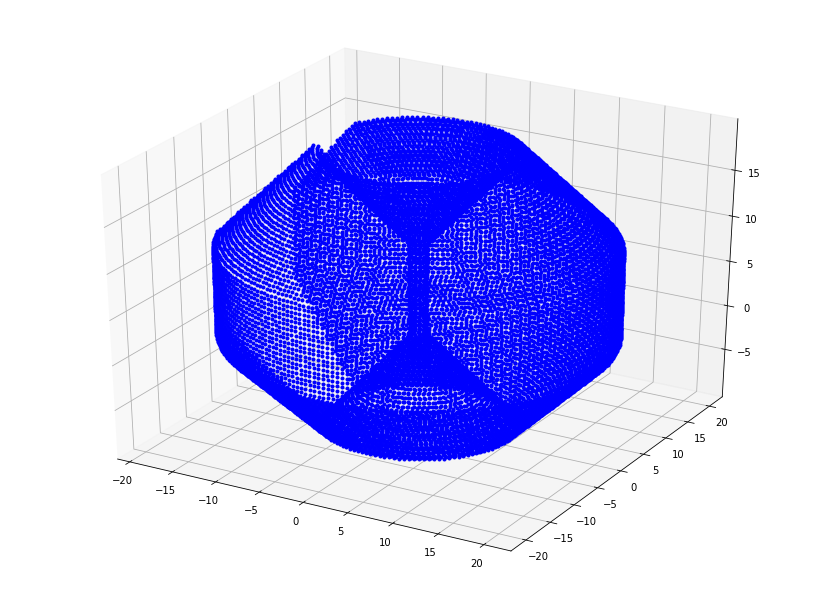

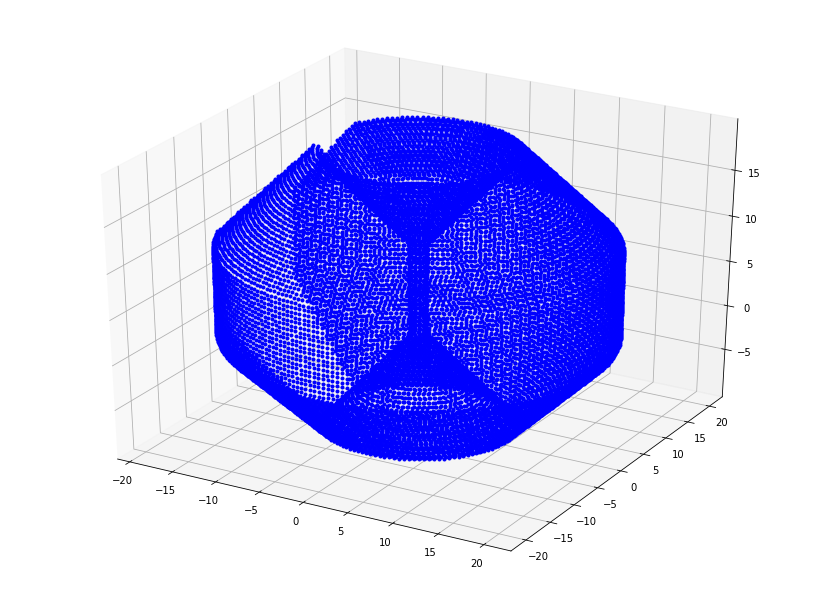

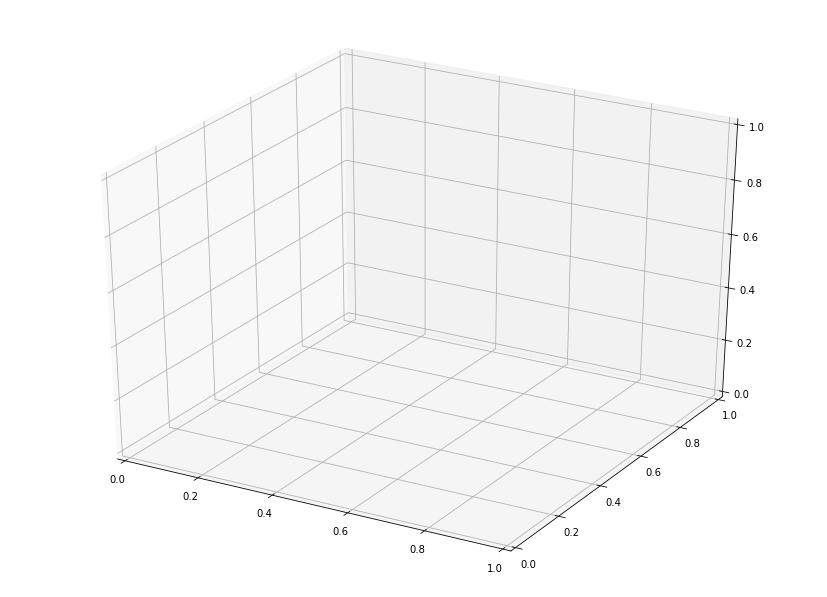

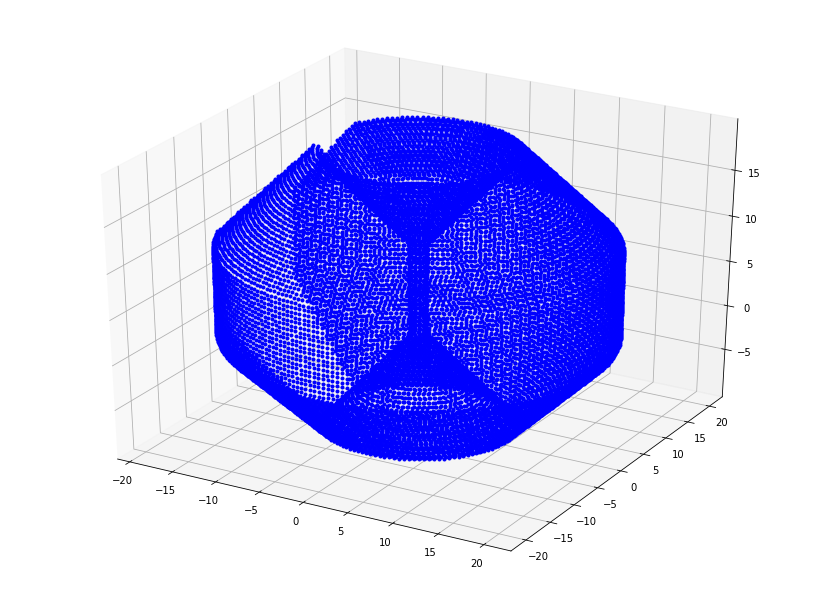

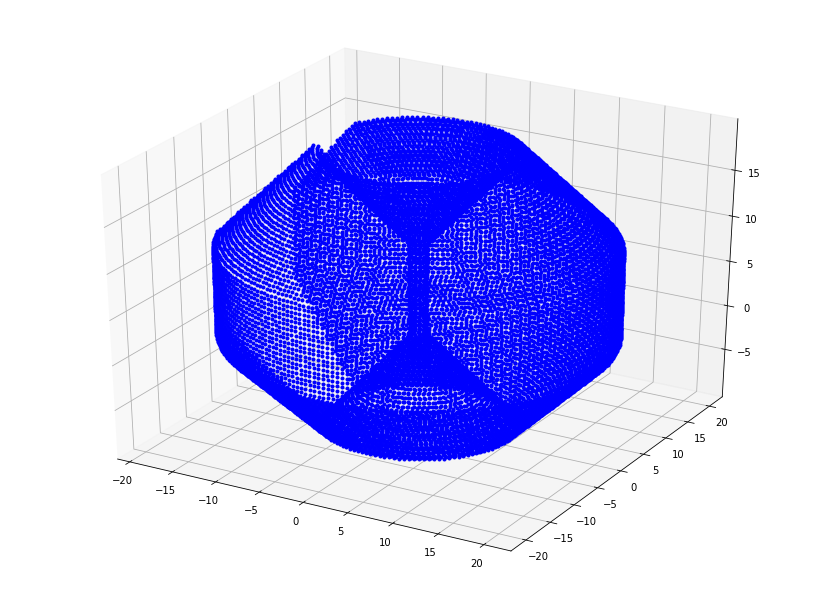

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
"""
f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax.plot(VPoly[0,:],VPoly[1,:],'-k')
ax.plot(Ptsm[0,:],Ptsm[1,:], 'xb')
ax.plot(VPbism[0,:], VPbism[1,:],'sr')
"""
f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8],projection='3d')
ax.plot(Pts[0,:],Pts[1,:], Pts[2,:],'.b')

f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8],projection='3d')
ax.plot(Ptsb[0,:],Ptsb[1,:], Ptsb[2,:],'.b')
"""
f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8],projection='3d')
inddiff = np.array([ii for ii in range(0,len(ind)) if not ind[ii] in indb])
inddiffb = np.array([ii for ii in range(0,len(indb)) if not indb[ii] in ind])
ax.plot(Pts[0,inddiff],Pts[1,inddiff], Pts[2,inddiff],'.b')
ax.plot(Ptsb[0,inddiffb],Ptsb[1,inddiffb], Ptsb[2,inddiffb],'or',ms=15)

f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8],projection='3d')
ax.plot(PtsS[0,:],PtsS[1,:], PtsS[2,:],'.b')

f = plt.figure(figsize=(14,10))
ax = f.add_axes([0.1,0.1,0.8,0.8],projection='3d')
ax.plot(PtsL[0,:],PtsL[1,:], PtsL[2,:],'.b')
"""
plt.show()

In [33]:
print(len(ind),np.all(ind==np.unique(ind)),ind)
print(len(indb),np.all(indb==np.unique(indb)),indb)
print(len(inddiff), inddiff)
print(len(inddiffb),inddiffb)

10196 False [  -6   -5   -4 ..., 5055 5056 5057]
2644 True [   0    1    2 ..., 5056 5057 5058]
4776 [    0     1     2 ..., 10185 10189 10193]
1 [2643]


/Applications/Anaconda/python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':
